In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import string
import networkx as nx
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset

# Extractive Summarization

### Data

In [2]:
train = load_dataset("cnn_dailymail", "3.0.0", split="train")
train.shape

(287113, 3)

In [3]:
val = load_dataset("cnn_dailymail", "3.0.0", split="validation")
val.shape

(13368, 3)

In [4]:
single_test = train[0]['article']
single_test

'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details o

### Preprocessing Functions

In [5]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
nltk.download('punkt') 
glove_path = 'Data/Glove/glove.6B.100d.txt'
dim = 100 ## depends on what Glove embeddings
frac = 0.2 # percent of text sentences to be used in abstraction

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\epaul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
nltk.download('punkt')  # one time execution
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\epaul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def rem_ascii(s):
    return "".join([c for c in s if ord(c) < 128 ])

In [8]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    processed = re.sub(r"\d+","",punc_free)
    return processed

In [9]:
def loadGloveModel(gloveFile):
    word_embeddings = {}
    f = open(gloveFile, encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    f.close()
    return word_embeddings


### Embeddings with GloVe

In [10]:
word_embeddings = loadGloveModel(glove_path)

In [11]:
sentences = sent_tokenize(single_test)
cleaned_texts = [rem_ascii(clean(sentence)) for sentence in sentences]

In [12]:
sentence_vectors = []
for i in cleaned_texts:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((dim,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((dim,))
    sentence_vectors.append(v)

### Similarity matrix of all sentences in text

[[0.    0.895 0.885 0.691 0.782 0.862 0.717 0.68  0.767 0.752 0.909 0.798
  0.862 0.776 0.861 0.776 0.83  0.825 0.826 0.825 0.806 0.538 0.402 0.663]
 [0.895 0.    0.882 0.754 0.816 0.889 0.723 0.664 0.789 0.759 0.863 0.808
  0.884 0.822 0.884 0.796 0.87  0.856 0.812 0.792 0.827 0.576 0.287 0.63 ]
 [0.885 0.882 0.    0.838 0.828 0.89  0.736 0.693 0.892 0.845 0.886 0.853
  0.959 0.895 0.848 0.826 0.836 0.844 0.86  0.829 0.909 0.528 0.342 0.69 ]
 [0.691 0.754 0.838 0.    0.753 0.73  0.618 0.538 0.871 0.817 0.728 0.765
  0.849 0.852 0.682 0.7   0.757 0.707 0.686 0.7   0.862 0.441 0.19  0.553]
 [0.782 0.816 0.828 0.753 0.    0.819 0.652 0.517 0.683 0.803 0.829 0.74
  0.789 0.813 0.77  0.739 0.79  0.721 0.709 0.693 0.784 0.419 0.349 0.666]
 [0.862 0.889 0.89  0.73  0.819 0.    0.713 0.578 0.742 0.791 0.896 0.787
  0.851 0.813 0.879 0.819 0.833 0.842 0.882 0.814 0.825 0.438 0.334 0.679]
 [0.717 0.723 0.736 0.618 0.652 0.713 0.    0.582 0.671 0.675 0.718 0.668
  0.748 0.674 0.781 0.723 0.707 0

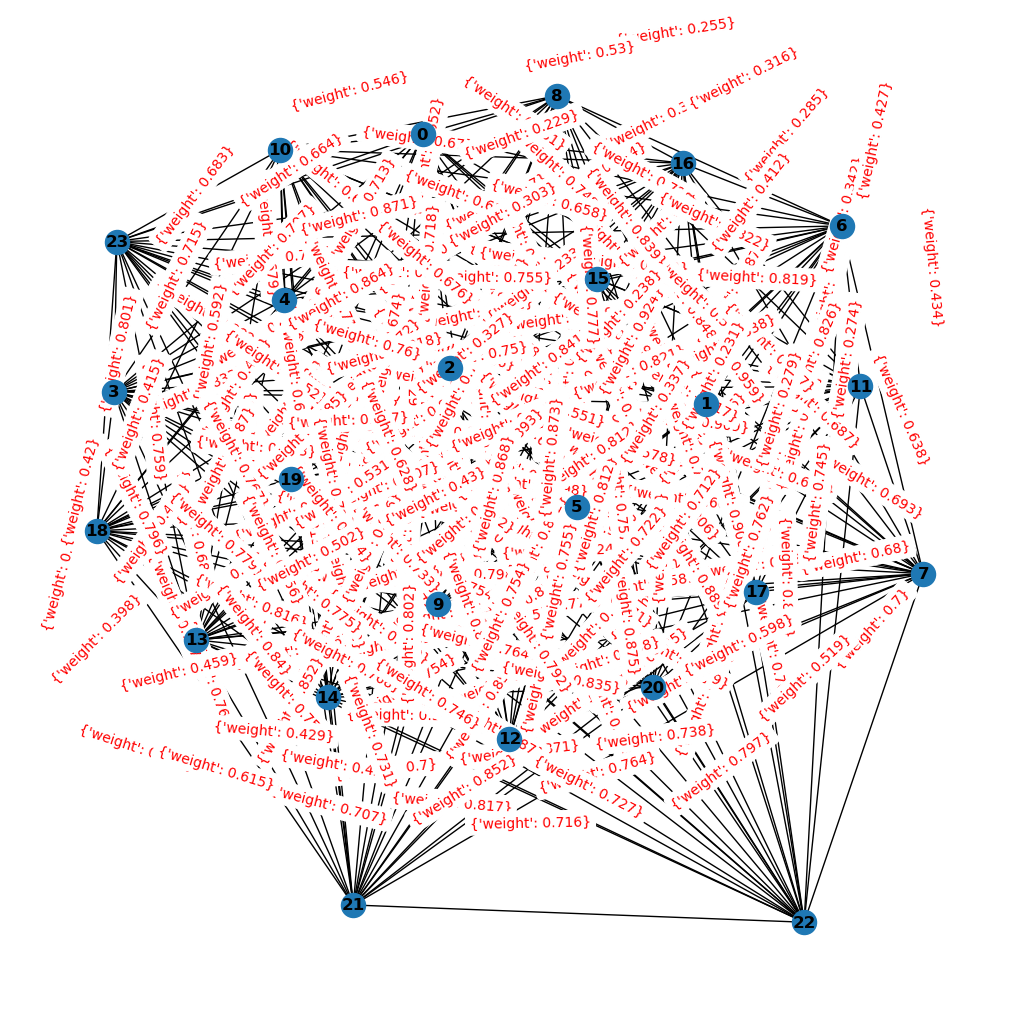

In [13]:
sim_mat = np.zeros([len(cleaned_texts), len(cleaned_texts)])
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,dim),sentence_vectors[j].reshape(1,dim))[0,0]
sim_mat = np.round(sim_mat,3)
print(sim_mat)

# Creating the network graph
nx_graph = nx.from_numpy_array(sim_mat)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
plt.show()

### TextRank Algorithm
##### picking most 'important' and encaptuirng sentences

In [14]:
scores = nx.pagerank(nx_graph)
print(scores)

{0: 0.044875651952270806, 1: 0.045161430290449264, 2: 0.04673841176246792, 3: 0.041184531095438084, 4: 0.042077329487586065, 5: 0.044778583063074306, 6: 0.03913785942740259, 7: 0.03643222661730464, 8: 0.04315412341027787, 9: 0.04269954100933796, 10: 0.04518685107973143, 11: 0.042106719455441484, 12: 0.04604106843352916, 13: 0.043838453882543475, 14: 0.04476048447591457, 15: 0.042786304794043606, 16: 0.044011331283157776, 17: 0.04410016643509872, 18: 0.04303514082075349, 19: 0.04261783688789744, 20: 0.04509621571672463, 21: 0.0299879871172812, 22: 0.02237690916157844, 23: 0.03781484234069503}


In [15]:
ranked_sentences = sorted(((scores[i],i) for i,s in enumerate(sentences)), reverse=True)
arranged_sentences = sorted(ranked_sentences[0:int(len(sentences)*frac)], key=lambda x:x[1])
print("\n".join([sentences[x[1]] for x in arranged_sentences]))

Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties.
"I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month.
Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch.
"People are always looking to say 'kid star goes off the rails,'" he told reporters last month.
